# Timeseries Forecasting with LSTM

The network architecture of Long short-term Memory Networks (LSTM) is optimized for learning sequences of events. For example, we can use LSTM to learn how texts are structured and use them to predict the most likely next word in a sentence. 

Another application is the forecast of time-series that are time-ordered
sequences of events. For example, the stock price of a share can be interpreted as a time series as well as  the sales of products and many more.

In this notebook we illustrate the principle of time-series forecasting with LSTM networks using a small generated dataset that consists of two sine functions with an additional noise term. We will use these networks to forecast the next data point in a series. In other words, we perform a "one-step ahead" forecast predicting one element at the time.

In [1]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

%pylab inline
# large figures
rcParams['figure.figsize'] = 8, 6
print(tf.__version__)

Populating the interactive namespace from numpy and matplotlib
2.2.0


## Generate data

We now create a small artificial dataset from two sine functions with an additional  noise term. The signal is periodic and therefore relatively simple to learn, however, the high frequency component and noise allow for some complexity.

In [0]:
##
## generate data - a simple sine with some noise
##
def generate_data(x_min, x_max, n_datapoints=300,
                  f1 = 10, f2=20, offset1 = 0, offset2=0.2, noise=0.1):
  x = np.linspace(x_min, x_max, n_datapoints)
  y = 0.5*np.sin(f1*(x-offset1))+0.2*sin(f2*(x-offset2))+noise*np.random.rand(n_datapoints)-0.5
  return x,y


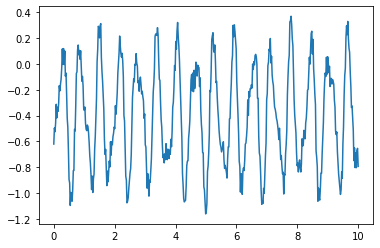

In [3]:
x,y = generate_data(x_min=0.0, x_max=10.0, n_datapoints=500,
                    f1=10, f2=17, offset1=0.1, offset2=0.3, noise=0.2)
plt.plot(x, y)
plt.show() 



## Transform data

We now need to transform the data in to a sliding window of a fixed width.
One key feature of sequences is that the data points are auto-correlated which means that the sequence of the data points matters.
In "normal" supervised learning approaches we would shuffle the training data and reserve a fraction chosen at random as the test data. 
In the case of time-series data, we cannot do this as the sequence of the data points is a key aspect of the structure of a time-series.

LSTM networks are a supervised training network where we predict a label (y_train) from a number of training data (x_data). In our case we take a part of the original training data by considering only a number n points at the time and then predict the next element that would follow immediately after this sequence of n points. 
Then we shift the window by one time-step (or data point), consider the next window of n data-points and predict the one following the the new sequence 
and repeat the process until we have processed the complete time-series.

Note that the first sequence of n points is used to create the first element of the sequence of the training targets y_train.

We also need to determine the length of the sequence. In this example we will use 50 points to approximately capture one period of the signal.

In [0]:
#use 50 points for the window width
sequence_length = 50 
sequence = []
for index in range(len(y) - sequence_length):
  sequence.append(y[index: index + sequence_length +1])
  
sequence = np.array(sequence)

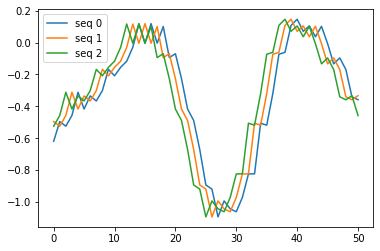

In [20]:
#
# Look at a few examples of the training sequences
#

plt.plot(sequence[0], label='seq 0')
plt.plot(sequence[1], label='seq 1')
plt.plot(sequence[2], label='seq 2')

#one towards the end
#seq_no = len(sequence)-int(len(sequence)/10.0)
#plt.plot(sequence[seq_no], label='seq '+ str(seq_no))

plt.legend()
plt.show()


We now split the sequences into a training and test dataset where
we use 80% of the data for training and retain 20% as an independent 
test sample. Since the data points are auto-correlated, we cannot take a random sample but need to take the last 20% of the data.
First we calculate the appropriate index to split the sequences into a training and test sample.

We then take the series of n data-points as the training data (x_train) and the next element in the series as the trainig target (y_train).

Finally, we need to bring the training and test data (x_train and x_test) into the shape expected by the LSTM network. The LSTM layers expect a three-dimensional tensor as input, where the elements specify:
   * the number of samples
   * the length of the sequence
   * the number of forecast steps. In our case we train the model to predict the element directly following the sequence and hence we set this to 1.

In [21]:
#use 80% for trainig, 20% for testing
train_index = round(0.8 * len(sequence))
print('The training data will run up to index {}'.format(train_index))

train = sequence[:int(train_index), :]
x_train = train[:, :-1]
y_train = train[:, -1]
x_test  = sequence[int(train_index):, :-1]
y_test  = sequence[int(train_index):, -1]

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) 

print(x_train.shape)


The training data will run up to index 360
(360, 50, 1)


Let's plot the training and test data in sequence, using black for the training and red for the test data. In our case we generated the data such that we have values for the x-axes in a separate data field.

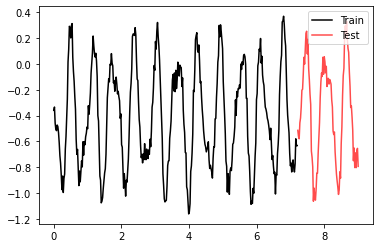

In [23]:
plt.plot(x[:train_index], y_train, label='Train', color='black',)
plt.plot(x[train_index:-sequence_length], y_test,  label='Test',  color='red', alpha=0.7)

plt.legend()
plt.show()

We now build a simple LSTM module with 50 nodes in the input layer and 100 nodes in the hidden layer. We also add a Dropout regularization after each LSTM layer.

Note that we need to specify the parameter ```return_sequences=True``` for each LSTM layer that is followed by another LSTM layer. This ensures that the full sequence of data-points is returned and can be processed by the next layer.

We use the mean squared error (MSE) as loss function, a batch size of 64 samples and the Adam optimizer with default values to determine the best parameters of the network.

In [36]:
###
### build the model
###

model = tf.keras.Sequential()

model.add(layers.LSTM(units=50, input_shape=(sequence_length,1), return_sequences=True ))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(units=100, return_sequences=False))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=1))
model.add(layers.Activation('linear'))

model.compile(loss='mse', optimizer='adam')

###
### fit model
###
history = model.fit(x_train,y_train, batch_size=64, epochs=500, validation_split=0.05)

Epoch 1/500
6/6 [==============================] - 1s 94ms/step - loss: 0.2422 - val_loss: 0.1296
Epoch 2/500
6/6 [==============================] - 0s 11ms/step - loss: 0.1586 - val_loss: 0.1127
Epoch 3/500
6/6 [==============================] - 0s 12ms/step - loss: 0.1217 - val_loss: 0.0984
Epoch 4/500
6/6 [==============================] - 0s 10ms/step - loss: 0.0933 - val_loss: 0.0334
Epoch 5/500
6/6 [==============================] - 0s 10ms/step - loss: 0.0494 - val_loss: 0.0184
Epoch 6/500
6/6 [==============================] - 0s 11ms/step - loss: 0.0401 - val_loss: 0.0362
Epoch 7/500
6/6 [==============================] - 0s 10ms/step - loss: 0.0316 - val_loss: 0.0184
Epoch 8/500
6/6 [==============================] - 0s 11ms/step - loss: 0.0310 - val_loss: 0.0101
Epoch 9/500
6/6 [==============================] - 0s 10ms/step - loss: 0.0271 - val_loss: 0.0155
Epoch 10/500
6/6 [==============================] - 0s 10ms/step - loss: 0.0227 - val_loss: 0.0202
Epoch 11/500
6/6 [=

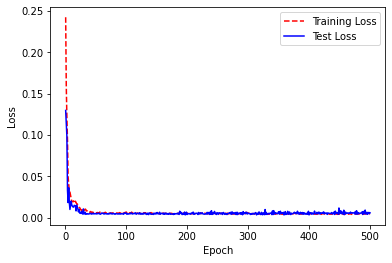

In [37]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

## Predictions on Test Data

We now use the independent test data that we have retained earlier to validate the network.
We start with the first sequence in the test data comprising of n consequtive data points and then predict the next point.
Then we add this prediction to the sequence and move the prediction window one step ahead and predict the next point. We keep iterating this approach until we have processed the complete test data.

In [0]:
# start from the first window in the test data, i.e. sequence_length number of points
# with shape (sequence_length,1)
current_window = x_test[0]
prediction = []

for i in range(len(x_test)):
    #LSTM cell expects 3D shape, add a new axis
    data_point = current_window[np.newaxis,:,:]
    
    #get a single number from the returned shape as the prediction
    pred = model.predict(data_point)[0,0]
    prediction.append(pred)

    
    #advance the input window to the LSTM cell, move the sequence one step up, add the prediction as the last number
    current_window = current_window[1:]
    current_window = np.insert(current_window,[sequence_length -1 ], values=prediction[-1], axis=0)
    



We now print the available data, starting with the training data. Then we overlay the known true values of the test data (in red) with the predictions
from the LSTM network (in blue).

On this scale the predictions are very accurate

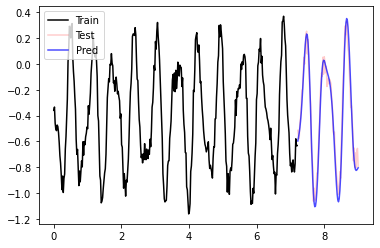

In [42]:


plt.plot(x[:train_index], y_train, label='Train', color='black',)
plt.plot(x[train_index:-sequence_length], y_test,  label='Test',  color='red', alpha=0.2)
plt.plot(x[train_index:-sequence_length], prediction,  label='Pred',  color='blue', alpha=0.7)
plt.legend()
plt.show()

Let's look at just the predictions and known true values.
The model can accurately reproduce the shape of the signal without following the extra noise. 


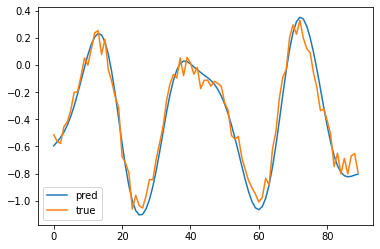

In [43]:
plt.plot(prediction, label='pred')
plt.plot(y_test, label='true')
plt.legend()
plt.show()
